In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [20]:
df = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_test.csv')
df = df[(df['label'] ==5) | (df['label'] ==6) | (df['label'] ==7) | (df['label'] ==0) | (df['label'] ==2)]

In [21]:
df['label'].value_counts()

label
2    1032
7    1028
0     980
6     958
5     892
Name: count, dtype: int64

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [23]:
class CSVDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.data = df[(df['label'] ==5) | (df['label'] ==6) | (df['label'] ==7) | (df['label'] ==0) | (df['label'] ==2)]
        self.X = self.data.iloc[:, :-1].values
        label_map = {0: 0, 2: 1, 5: 2, 6: 3, 7: 4}
        self.y = self.data['label'].map(label_map).values
        #self.y = self.data.iloc[:, -1].values
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

In [24]:
train_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_train.csv')
test_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_test.csv')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
activation_functions = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "swish": nn.SiLU
}

In [27]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation_name):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.activation = activation_functions[activation_name.lower()]()
            
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        #x = F.softmax(x, dim=1)
        return x

def train_model(model, optimizer, criterion, epochs=50):
    criterion = nn.CrossEntropyLoss()
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()
        avg_loss = total_loss/len(train_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        losses.append(avg_loss)

    return losses


In [28]:
model = NeuralNetwork(28*28, 128, 64, 5, 'relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
losses_relu = train_model(model, optimizer, criterion, epochs=50)

Epoch 1, Loss: 0.1782
Epoch 2, Loss: 0.0636
Epoch 3, Loss: 0.0517
Epoch 4, Loss: 0.0462
Epoch 5, Loss: 0.0462
Epoch 6, Loss: 0.0356
Epoch 7, Loss: 0.0333
Epoch 8, Loss: 0.0325
Epoch 9, Loss: 0.0285
Epoch 10, Loss: 0.0282
Epoch 11, Loss: 0.0235
Epoch 12, Loss: 0.0359
Epoch 13, Loss: 0.0195
Epoch 14, Loss: 0.0201
Epoch 15, Loss: 0.0160
Epoch 16, Loss: 0.0214
Epoch 17, Loss: 0.0235
Epoch 18, Loss: 0.0183
Epoch 19, Loss: 0.0166
Epoch 20, Loss: 0.0163
Epoch 21, Loss: 0.0175
Epoch 22, Loss: 0.0152
Epoch 23, Loss: 0.0215
Epoch 24, Loss: 0.0124
Epoch 25, Loss: 0.0160
Epoch 26, Loss: 0.0053
Epoch 27, Loss: 0.0197
Epoch 28, Loss: 0.0178
Epoch 29, Loss: 0.0101
Epoch 30, Loss: 0.0131
Epoch 31, Loss: 0.0161
Epoch 32, Loss: 0.0145
Epoch 33, Loss: 0.0111
Epoch 34, Loss: 0.0114
Epoch 35, Loss: 0.0166
Epoch 36, Loss: 0.0113
Epoch 37, Loss: 0.0127
Epoch 38, Loss: 0.0025
Epoch 39, Loss: 0.0112
Epoch 40, Loss: 0.0137
Epoch 41, Loss: 0.0165
Epoch 42, Loss: 0.0206
Epoch 43, Loss: 0.0089
Epoch 44, Loss: 0.00

In [30]:
model2 = NeuralNetwork(28*28, 128, 64, 5, 'sigmoid').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [31]:
losses_sigmoid = train_model(model2, optimizer, criterion, epochs=50)

Epoch 1, Loss: 0.3012
Epoch 2, Loss: 0.1419
Epoch 3, Loss: 0.1318
Epoch 4, Loss: 0.1222
Epoch 5, Loss: 0.1136
Epoch 6, Loss: 0.1043
Epoch 7, Loss: 0.1038
Epoch 8, Loss: 0.1015
Epoch 9, Loss: 0.0954
Epoch 10, Loss: 0.0960
Epoch 11, Loss: 0.0923
Epoch 12, Loss: 0.0924
Epoch 13, Loss: 0.0863
Epoch 14, Loss: 0.0822
Epoch 15, Loss: 0.0845
Epoch 16, Loss: 0.0751
Epoch 17, Loss: 0.0740
Epoch 18, Loss: 0.0698
Epoch 19, Loss: 0.0682
Epoch 20, Loss: 0.0679
Epoch 21, Loss: 0.0686
Epoch 22, Loss: 0.0664
Epoch 23, Loss: 0.0651
Epoch 24, Loss: 0.0663
Epoch 25, Loss: 0.0603
Epoch 26, Loss: 0.0626
Epoch 27, Loss: 0.0624
Epoch 28, Loss: 0.0578
Epoch 29, Loss: 0.0566
Epoch 30, Loss: 0.0574
Epoch 31, Loss: 0.0586
Epoch 32, Loss: 0.0553
Epoch 33, Loss: 0.0555
Epoch 34, Loss: 0.0566
Epoch 35, Loss: 0.0517
Epoch 36, Loss: 0.0499
Epoch 37, Loss: 0.0509
Epoch 38, Loss: 0.0491
Epoch 39, Loss: 0.0528
Epoch 40, Loss: 0.0513
Epoch 41, Loss: 0.0498
Epoch 42, Loss: 0.0508
Epoch 43, Loss: 0.0455
Epoch 44, Loss: 0.04

In [32]:
model3 = NeuralNetwork(28*28, 128, 64, 5, 'tanh').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

In [33]:
losses_tanh = train_model(model3, optimizer, criterion, epochs=50)

Epoch 1, Loss: 0.2511
Epoch 2, Loss: 0.1790
Epoch 3, Loss: 0.1454
Epoch 4, Loss: 0.1391
Epoch 5, Loss: 0.1414
Epoch 6, Loss: 0.1340
Epoch 7, Loss: 0.1244
Epoch 8, Loss: 0.1149
Epoch 9, Loss: 0.1152
Epoch 10, Loss: 0.1191
Epoch 11, Loss: 0.1034
Epoch 12, Loss: 0.1093
Epoch 13, Loss: 0.1065
Epoch 14, Loss: 0.1025
Epoch 15, Loss: 0.1002
Epoch 16, Loss: 0.0968
Epoch 17, Loss: 0.0991
Epoch 18, Loss: 0.0972
Epoch 19, Loss: 0.0917
Epoch 20, Loss: 0.0880
Epoch 21, Loss: 0.0864
Epoch 22, Loss: 0.0756
Epoch 23, Loss: 0.0753
Epoch 24, Loss: 0.0777
Epoch 25, Loss: 0.0795
Epoch 26, Loss: 0.0771
Epoch 27, Loss: 0.0789
Epoch 28, Loss: 0.0773
Epoch 29, Loss: 0.0761
Epoch 30, Loss: 0.0759
Epoch 31, Loss: 0.0747
Epoch 32, Loss: 0.0730
Epoch 33, Loss: 0.0692
Epoch 34, Loss: 0.0665
Epoch 35, Loss: 0.0661
Epoch 36, Loss: 0.0652
Epoch 37, Loss: 0.0679
Epoch 38, Loss: 0.0651
Epoch 39, Loss: 0.0637
Epoch 40, Loss: 0.0642
Epoch 41, Loss: 0.0744
Epoch 42, Loss: 0.0693
Epoch 43, Loss: 0.0684
Epoch 44, Loss: 0.06

In [34]:
model4 = NeuralNetwork(28*28, 128, 64, 5, 'swish').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=0.001)

In [35]:
losses_swish = train_model(model4, optimizer, criterion, epochs=50)

Epoch 1, Loss: 0.1948
Epoch 2, Loss: 0.0668
Epoch 3, Loss: 0.0502
Epoch 4, Loss: 0.0444
Epoch 5, Loss: 0.0390
Epoch 6, Loss: 0.0370
Epoch 7, Loss: 0.0333
Epoch 8, Loss: 0.0298
Epoch 9, Loss: 0.0316
Epoch 10, Loss: 0.0291
Epoch 11, Loss: 0.0286
Epoch 12, Loss: 0.0268
Epoch 13, Loss: 0.0231
Epoch 14, Loss: 0.0302
Epoch 15, Loss: 0.0148
Epoch 16, Loss: 0.0181
Epoch 17, Loss: 0.0225
Epoch 18, Loss: 0.0164
Epoch 19, Loss: 0.0135
Epoch 20, Loss: 0.0231
Epoch 21, Loss: 0.0141
Epoch 22, Loss: 0.0217
Epoch 23, Loss: 0.0166
Epoch 24, Loss: 0.0115
Epoch 25, Loss: 0.0206
Epoch 26, Loss: 0.0139
Epoch 27, Loss: 0.0104
Epoch 28, Loss: 0.0120
Epoch 29, Loss: 0.0240
Epoch 30, Loss: 0.0150
Epoch 31, Loss: 0.0082
Epoch 32, Loss: 0.0141
Epoch 33, Loss: 0.0075
Epoch 34, Loss: 0.0124
Epoch 35, Loss: 0.0152
Epoch 36, Loss: 0.0218
Epoch 37, Loss: 0.0098
Epoch 38, Loss: 0.0040
Epoch 39, Loss: 0.0145
Epoch 40, Loss: 0.0056
Epoch 41, Loss: 0.0107
Epoch 42, Loss: 0.0134
Epoch 43, Loss: 0.0065
Epoch 44, Loss: 0.00

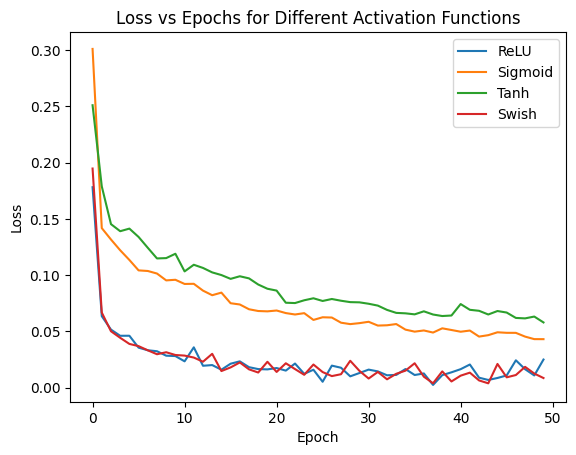

In [36]:
import matplotlib.pyplot as plt

plt.plot(losses_relu, label='ReLU')
plt.plot(losses_sigmoid, label='Sigmoid')
plt.plot(losses_tanh, label='Tanh')
plt.plot(losses_swish, label='Swish')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs for Different Activation Functions")
plt.legend()
plt.show()
